## Simulation of between-subjects regressor effects on HDDM parameters

This notebook is slightly modified from the `.py` posted by Michael, see [here](https://groups.google.com/g/hddm-users/c/C96uz2_xFl8) for the discussion.

The goal of this script is to verify that effects of between-subjects regressor on 
HDDM parameters can be accurately estimated, including when there are also within-subject effects. That is, to see if we can estimate within HDDM the impact of a continuous measure x, where x can be age, IQ, etc on DDM params. 

Values of a between-subject regressor on a or v are simulated by creating multiple subject datasets at increasing
values of the regressor.  


Michael Frank had reiterated a point from a previous post though, based on [this article](https://www.sciencedirect.com/science/article/pii/S0022249616300025), that it is actually fine to fit the model without x as a regressor at all, and then to correlate the individual subject intercepts with the between subjects factor after the fact  -- but that involves a classical correlation test whereas the regression approach here estimates the effect and its uncertainty within the bayesian parameter estimation itself. 

Here are some issues to consider when doing this as pointed out by Michael Frank:

1. A central issue that came up is that when estimating parameters, they should still be informed by, and in the range of, the priors. The intercept parameters for the main DDM parameters are informed by empirical priors (see the supplement of the [2013 paper](https://www.frontiersin.org/articles/10.3389/fninf.2013.00014/full)), and so my earlier recommendation (in [that thread](https://groups.google.com/g/hddm-users/c/C96uz2_xFl8)) to try $a$ ~ 0 + X was misguided because it would enforce the intercept to be 0 which has very low prior density for $a$  (this is not a problem for $v$ ~ 0 + X, given that 0 is in the range of priors for drift, but it turns out there is no need to enforce  intercepts to be 0 after all -- which is good because one would usually like to still estimate indiv subject parameters that reflect variability beyond that explained by the single x factor).   

2. Relatedly, a key recommendation is to first z-score (or at least mean-center) the between subjects factor x and to then estimate e.g., a ~ 1 + X. This way every subject still has an intercept drawn from an overall group distribution, with priors of that distribution centered at empirical priors, but then we can also estimate the degree to which this intercept is modified up or down by the (z-scored / mean-centered) between-subjects factor.

The simulation and parameter recovery confirmed that the beta coefficient on the x factor is recovered quite well at least for the various cases that Michael had tried. (In the generative data, the intercepts should also be within the range of priors for this to work reliably (e.g. a_int > 0), which makes sense). He (Michael) also confirmed that this works for both threshold and drift (and I image t should be fine too), and when allowing both to vary freely during fitting it correctly estimated the magnitude of the specific factor that varied in generative data, and pinned the other one at ~zero). 


* Note one limitation in the implementation is that while we allow x to affect the mean of the group distribution on the intercept, we assume the variance of that distribution is constant across levels of x - ie. there is no way currently to allow a_std to vary with x. But that's not such a terrible limitation (it just means that a_std for the overall group parameters will need to be large enough to accommodate the most variable group - but it should still go *down* relative to not allowing x to influence the mean at all).  

In [1]:
import hddm
from numpy import mean, std
import numpy as np         
from pandas import Series
import pandas as pd
import os as os
import matplotlib.pyplot as plt

# os.chdir('/storage/home/mnh5174')


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


### Stimulation with between-subject regressor

Note that the commented code, you can find the way to sitmulate between-subject regressor with a within-subject condition (level 1 and level 2)

#### Generate data

Here the simulation assume that there is no interaction between the inter-subject regressor and within-subject condition. So the setting is $ a = int_{a} + \beta_{a} * X$, the level 1 is $a$ and level 2 is $a+0.5$. 

But what if $a$ interacts with different levels, e.g., level 1 is $ a1 = int_{a1} + \beta_{a1} * X $, and level 2 is $ a2 = int_{a2} + \beta_{a2} * X $?

In [2]:
beta_a = 0.4   # between subjects scaling factor - adjust this and should be able to recover its true value
a_int = 1      # set intercept within range of empirical priors 
v_int = 0.3
x_range = range(11)   # set values of between subject measures, here from 0 to 10
trials_per_level = 200    
subjs_per_bin = 10

data_group = pd.DataFrame()  # empty df to append to  

for x in x_range:
    xx = (x - mean(x_range)) / std(x_range)  # z-score the x factor
    a = a_int + beta_a * xx  #  indiv subj param values that are centered on intercept but deviate from it up or down by z-scored x
    # v = v_int+ beta_a*xx  # can also do for drift, here using same beta coeff
    
    # parvec = {'v':.3, 'a':a, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    # parvec2 = {'v':.3, 'a':a+.5, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    parvec = {'v':.3, 'a':a, 't':.3}  # set a to value set by regression, here v is set to constant

    # note that for subjs_per_bin > 1, these are just the mean values of the parameters; indiv subjs within bin are sampled from distributions with the given means, but can still differ within bin around those means. 
    #not including sv, sz, st in the statement ensures those are actually 0.

    data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec}, size=trials_per_level, subjs=subjs_per_bin)
    
    # can also do with two levels of within-subj conditions
    # data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec,'level2': parvec2}, size=trials_per_level, subjs=subjs_per_bin)

    data_a['z_x'] = Series(xx * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['x'] = Series(x * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['a_population'] = Series(a * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['subj_idx'] = Series(x * subjs_per_bin + data_a['subj_idx'] * np.ones((len(data_a))), index=data_a.index)  # store the correct subj_idx when iterating over multiple subjs per bin
     
    # concatenate data_a with group data
    data_a_df = pd.DataFrame(data=[data_a])
    data_group = data_group.append([data_a], ignore_index=True)

#write original simulated data to file
data_group.to_csv('data_group.csv')

### Recover parameters

In [3]:
a_reg = {'model': 'a ~ 1 + z_x', 'link_func': lambda x: x}
# a_reg_within = {'model': 'a ~ 1+x + C(condition)', 'link_func': lambda x: x}
# for including and estimating within subject effects of  condition

v_reg = {'model': 'v ~ 1 + z_x', 'link_func': lambda x: x}
reg_comb = [a_reg, v_reg]
# m_reg = hddm.HDDMRegressor(data_group, reg_comb, group_only_regressors=['true']) 

# Do not estimate individual subject parameters for all regressors.
m_reg = hddm.HDDMRegressor(data_group, a_reg, group_only_regressors=['true'])
m_reg.find_starting_values()
m_reg.sample(3000, burn=500, dbname='a_bwsubs_t200.db', db='pickle')
m_reg.save('a_bwsubs_model_t200')

m_reg.print_stats()  # check values of reg coefficients against the generated ones

Adding these covariates:
['a_Intercept', 'a_z_x']


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 3001 of 3000 complete in 4287.3 secWARNING: Will not save custom link functions.
                            mean       std      2.5q       25q       50q       75q     97.5q    mc err
v                       0.325144  0.017820  0.289625  0.313217  0.325032  0.337229  0.360310  0.000737
v_std                   0.109973  0.020171  0.070226  0.096745  0.109675  0.123076  0.152067  0.001418
v_subj.0.0              0.363587  0.110533  0.146917  0.292865  0.360106  0.432667  0.593871  0.002181
v_subj.1.0              0.324692  0.110679  0.095627  0.255560  0.327596  0.394070  0.551594  0.002278
v_subj.2.0              0.348583  0.110807  0.131570  0.276615  0.347867  0.421789  0.569165  0.002322
v_subj.3.0              0.299380  0.108130  0.079324  0.228556  0.300519  0.371850  0.507152  0.002209
v_subj.4.0              0.351559  0.111310  0.130279  0.277739  0.354731  0.424338  0.565312  0.002622
v_subj.5.0              0.326366  0.108863  0.100277 

### load from file and examine recovery

In [4]:
#load from file and examine recovery
m_reg = hddm.load('a_bwsubs_model_t200')
data_group = pd.read_csv('data_group.csv')

#look at correlation of recovered parameter with original
subjdf = data_group.groupby('subj_idx').first().reset_index()

## check for residual correlation with x 
a_int_recovered =[]

#obtain mean a intercept parameter for subjects
from scipy import stats
for i in range(0,(1+max(x_range))*subjs_per_bin):
    a='a_Intercept_subj.'
    a+=str(i)
    a+='.0'
    p1=m_reg.nodes_db.node[a] 
    a_int_recovered.append(p1.trace().mean())
    
#obtain mean a regression weight for z_x
a_x_recovered = m_reg.nodes_db.node['a_z_x'].trace().mean()

#compute predicted a parameter as a function of subject intercept and between-subjects regressor
subjdf.apred = a_int_recovered + a_x_recovered * subjdf.z_x


Pearson correlation between a_x and x
(0.9762506833861541, 1.429214596270688e-73)


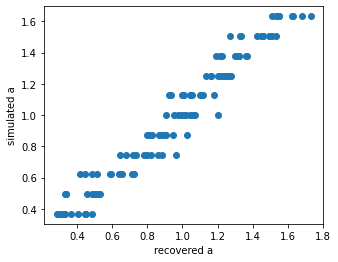

In [5]:
# correlation of recovered a with population a. r = .97 here: good!
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf.apred,subjdf.a_population) # predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf.apred,subjdf.a_population)) # correlation between predicted a value and population a value

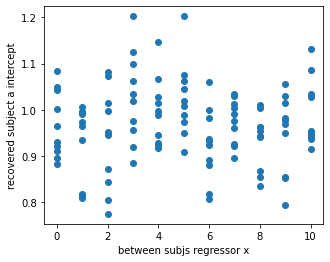

Pearson correlation between a_x and x
(0.002178625596488262, 0.9819784214850871)


<Figure size 432x288 with 0 Axes>

In [6]:
# correlation of subject intercept with between-subjects regressor
# should be zero correlation if entirely accounted for by x regressor - 
# this correlation should instead be positive if x is removed from the model fit
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf.x,a_int_recovered)
plt.xlabel('between subjs regressor x')
plt.ylabel('recovered subject a intercept')
plt.show()
plt.savefig('residual correlation between subj intercept and x.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(a_int_recovered,subjdf.x))


### Stimulation with between-within interaction


#### Generate data

Here we simulate the interaction between between-subject regressor and within subject variable

$a$ interacts with different levels, e.g., level 1 is $$ a1 = int_{a1} + \beta_{a1} * X $$, and level 2 is $$ a2 = int_{a2} + \beta_{a2} * X $$?

In [5]:
beta_a1 = 0.4   # between subjects scaling factor - adjust this and should be able to recover its true value
beta_a2 = 0.1
a_int = 1      # set intercept within range of empirical priors 
v_int = 0.3
x_range = range(11)   # set values of between subject measures, here from 0 to 10
trials_per_level = 100    
subjs_per_bin = 15

data_group = pd.DataFrame()  # empty df to append to  

for x in x_range:
    xx = (x - mean(x_range)) / std(x_range)  # z-score the x factor
    a1 = a_int + beta_a1 * xx  #  indiv subj param values that are centered on intercept but deviate from it up or down by z-scored x
    a2 = a_int + beta_a2 * xx 
    # v = v_int+ beta_a*xx  # can also do for drift, here using same beta coeff
    
    parvec = {'v':.3, 'a':a1, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    parvec2 = {'v':.3, 'a':a2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    # parvec = {'v':.3, 'a':a, 't':.3}  # set a to value set by regression, here v is set to constant

    # note that for subjs_per_bin > 1, these are just the mean values of the parameters; indiv subjs within bin are sampled from distributions with the given means, but can still differ within bin around those means. 
    #not including sv, sz, st in the statement ensures those are actually 0.

    # data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec}, size=trials_per_level, subjs=subjs_per_bin)
    
    # can also do with two levels of within-subj conditions
    data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec,'level2': parvec2}, size=trials_per_level, subjs=subjs_per_bin)

    data_a['z_x'] = Series(xx * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['x'] = Series(x * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    #data_a['a_population'] = Series(a * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['a_population'] = Series(a1 * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a.loc[data_a['condition'] == 'level2', 'a_population'] = a2
    data_a['subj_idx'] = Series(x * subjs_per_bin + data_a['subj_idx'] * np.ones((len(data_a))), index=data_a.index)  # store the correct subj_idx when iterating over multiple subjs per bin
     
    # concatenate data_a with group data
    data_a_df = pd.DataFrame(data=[data_a])
    data_group = data_group.append([data_a], ignore_index=True)

#write original simulated data to file
data_group.to_csv('data_group_int.csv')

Text(0, 0.5, 'simulated a')

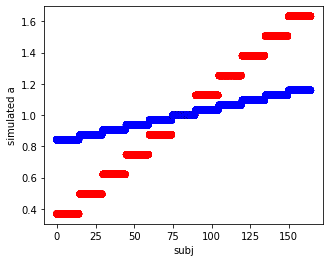

In [6]:
colors = np.where(data_group["condition"]== 'level1','r','b')
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(data_group.subj_idx,data_group.a_population, c=colors) # predicted versus observed a
plt.xlabel('subj')
plt.ylabel('simulated a')

In [7]:
# pd.unique(data_a[['a_population','condition']])

df = data_group.groupby(['subj_idx','a_population', 'condition']).size()
df.tail(30)

subj_idx  a_population  condition
150.0     1.158114      level2       100
          1.632456      level1       100
151.0     1.158114      level2       100
          1.632456      level1       100
152.0     1.158114      level2       100
          1.632456      level1       100
153.0     1.158114      level2       100
          1.632456      level1       100
154.0     1.158114      level2       100
          1.632456      level1       100
155.0     1.158114      level2       100
          1.632456      level1       100
156.0     1.158114      level2       100
          1.632456      level1       100
157.0     1.158114      level2       100
          1.632456      level1       100
158.0     1.158114      level2       100
          1.632456      level1       100
159.0     1.158114      level2       100
          1.632456      level1       100
160.0     1.158114      level2       100
          1.632456      level1       100
161.0     1.158114      level2       100
          1.632456     

In [8]:
# a_reg_within = {'model': 'a ~ 1+x + C(condition)', 'link_func': lambda x: x}
# for including and estimating within subject effects of  condition

# try main effect of within and interaction between within and between-subject
a_reg = {'model': 'a ~ 1 + z_x:condition + C(condition)', 'link_func': lambda x: x}

v_reg = {'model': 'v ~ 1 + z_x:condition + C(condition)', 'link_func': lambda x: x}
reg_comb = [a_reg, v_reg]
# m_reg = hddm.HDDMRegressor(data_group, reg_comb, group_only_regressors=['true']) 

# Do not estimate individual subject parameters for all regressors.
m_reg = hddm.HDDMRegressor(data_group, a_reg, group_only_regressors=['true'])
m_reg.find_starting_values()
m_reg.sample(2000, burn=500, dbname='a_bwsubs_int.db', db='pickle')
m_reg.save('a_bwsubs_int')

m_reg.print_stats()  # check values of reg coefficients against the generated ones

Adding these covariates:
['a_Intercept', 'a_C(condition)[T.level2]', 'a_z_x:condition[level1]', 'a_z_x:condition[level2]']


/home/hcp4715/miniconda3/envs/hddm/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 7031.3 secWARNING: Will not save custom link functions.
                              mean       std      2.5q       25q       50q       75q     97.5q    mc err
v                         0.295395  0.036004  0.227931  0.269921  0.294699  0.319699  0.366646  0.000936
v_std                     0.436072  0.028166  0.382754  0.416719  0.434707  0.454240  0.494150  0.001014
v_subj.0.0                0.737261  0.185299  0.369591  0.605278  0.738814  0.869315  1.078442  0.004588
v_subj.1.0                0.377881  0.194673 -0.007309  0.249125  0.381524  0.512975  0.759792  0.004786
v_subj.2.0                0.557877  0.174540  0.206340  0.439521  0.561773  0.681397  0.890828  0.004786
v_subj.3.0               -0.057948  0.212163 -0.463869 -0.207801 -0.058667  0.087053  0.353426  0.005388
v_subj.4.0               -0.574952  0.177568 -0.926366 -0.692187 -0.574182 -0.458446 -0.216296  0.004756
v_subj.5.0               -0.540603  0

In [4]:
beta_a1 = 0.4   # between subjects scaling factor - adjust this and should be able to recover its true value
beta_a2 = 0.1
a_int = 1      # set intercept within range of empirical priors 
v_int = 0.3
x_range = range(11)   # set values of between subject measures, here from 0 to 10
trials_per_level = 200    
subjs_per_bin = 10

In [9]:
#load from file and examine recovery
#m_reg = hddm.load('a_bwsubs_int')
#data_group = pd.read_csv('data_group_int.csv')

#look at correlation of recovered parameter with original
subjdf = data_group.groupby(['subj_idx','condition']).first().reset_index()



Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_C(condition)[T.level2]
Plotting a_z_x:condition[level1]
Plotting a_z_x:condition[level2]


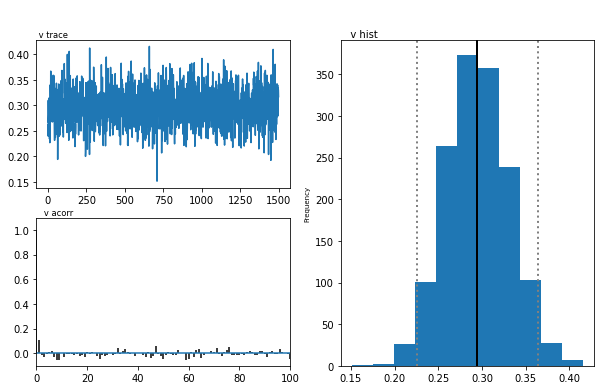

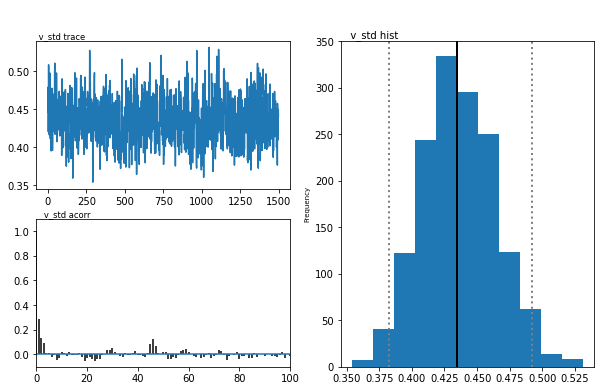

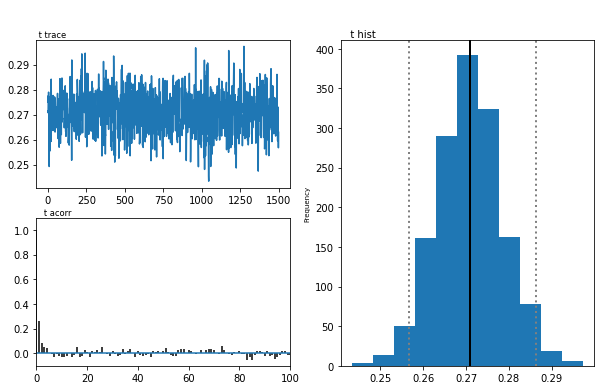

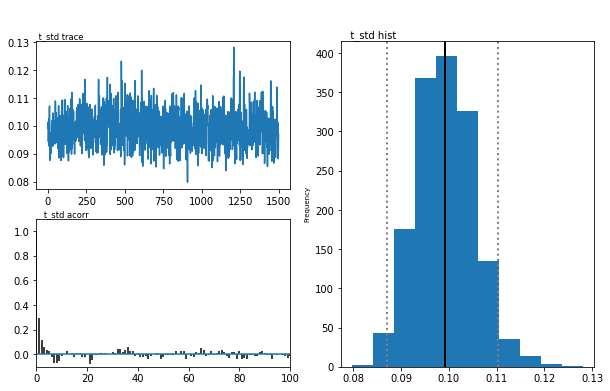

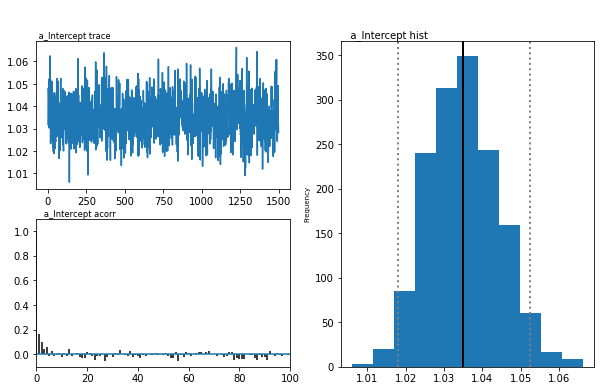

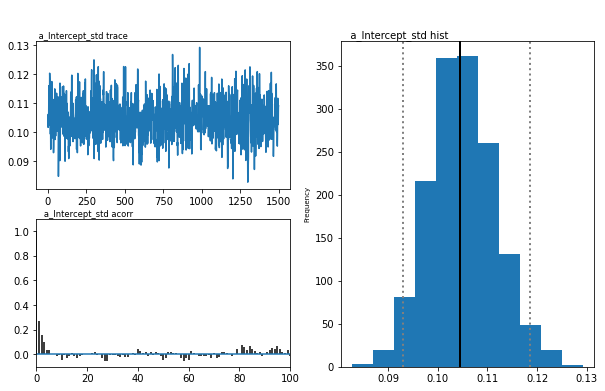

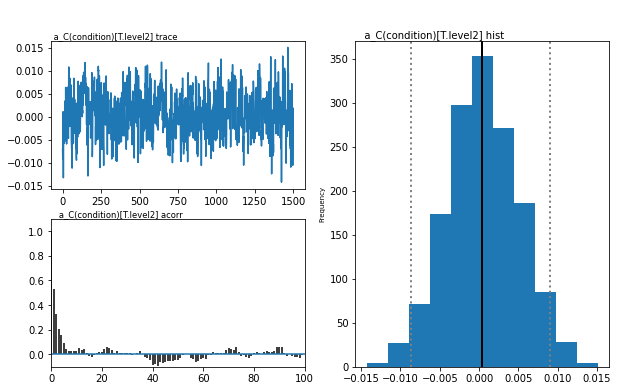

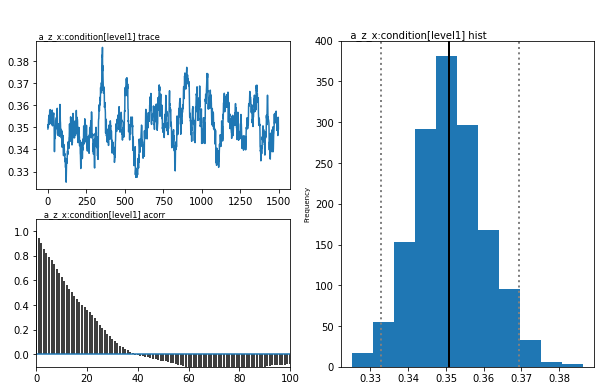

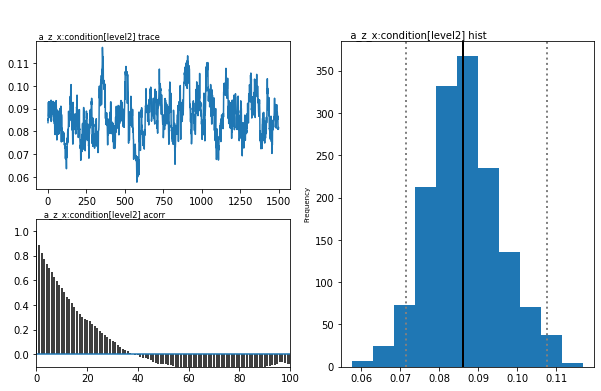

In [10]:
m_reg.plot_posteriors()

In [11]:
subjdf

,subj_idx,condition,rt,response,z_x,x,a_population
0,0.0,level1,0.057261,1.0,-1.581139,0.0,0.367544
1,0.0,level2,0.983267,0.0,-1.581139,0.0,0.841886
2,1.0,level1,0.373559,0.0,-1.581139,0.0,0.367544
3,1.0,level2,0.522679,1.0,-1.581139,0.0,0.841886
4,2.0,level1,0.241631,1.0,-1.581139,0.0,0.367544
...,...,...,...,...,...,...,...
325,162.0,level2,0.625537,0.0,1.581139,10.0,1.158114
326,163.0,level1,0.754495,0.0,1.581139,10.0,1.632456
327,163.0,level2,0.382027,0.0,1.581139,10.0,1.158114
328,164.0,level1,0.550370,0.0,1.581139,10.0,1.632456


In [13]:
from scipy import stats
a='a_Intercept_subj.'
a+=str(0)
a+='.0'
a


'a_Intercept_subj.0.0'

In [14]:
a_int_recovered =[]
p1=m_reg.nodes_db.node[a] 
a_int_recovered.append(p1.trace().mean())

In [15]:
p1.trace()

array([1.14549227, 1.15566628, 1.12422726, ..., 1.13114651, 1.15126963,
       1.13738068])

In [16]:
## check for residual correlation with x 
a_int_recovered =[]

# obtain mean a intercept parameter for subjects
from scipy import stats
for i in range(0,(1+max(x_range))*subjs_per_bin):
    a='a_Intercept_subj.'
    a+=str(i)
    a+='.0'
    p1=m_reg.nodes_db.node[a] 
    a_int_recovered.append(p1.trace().mean())
    a_int_recovered.append(p1.trace().mean()) # repeat the intercept one more time for the level2
    
#obtain mean a regression weight for z_x  (slope)

a_x_recovered_1 = m_reg.nodes_db.node['a_z_x:condition[level1]'].trace().mean()
a_x_recovered_2 = m_reg.nodes_db.node['a_z_x:condition[level2]'].trace().mean()

In [17]:
a_int_recovered + a_x_recovered_1 * subjdf.z_x

0      0.582886
1      0.582886
2      0.437746
3      0.437746
4      0.564277
         ...   
325    1.573362
326    1.666040
327    1.666040
328    1.548929
329    1.548929
Name: z_x, Length: 330, dtype: float64

In [18]:
#compute predicted a parameter as a function of subject intercept and between-subjects regressor
subjdf['a_int_recovered'] = a_int_recovered
subjdf.loc[subjdf['condition'] == 'level1', 'apred'] = a_int_recovered + a_x_recovered_1 * subjdf.z_x
subjdf.loc[subjdf['condition'] == 'level2', 'apred'] = a_int_recovered + a_x_recovered_2 * subjdf.z_x

Pearson correlation between a_x and x
(0.962856327279455, 1.3410360977363505e-94)


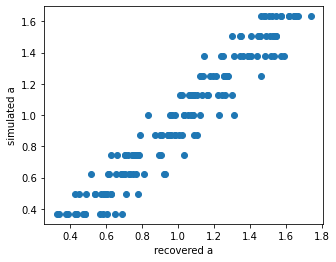

In [19]:
# correlation of recovered a with population a. r = .97 here: good!
subjdf1 = subjdf[subjdf['condition']=='level1']
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf1.apred,subjdf1.a_population) # predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
# plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf1.apred,subjdf1.a_population)) # correlation between predicted a value and population a value

Pearson correlation between a_x and x
(0.6561220659629358, 1.1162384950308774e-21)


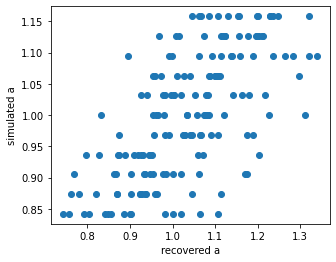

In [24]:
# correlation of recovered a with population a. r = .97 here: good!
subjdf2 = subjdf[subjdf['condition']=='level2']
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf2.apred,subjdf2.a_population) # predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
#plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf2.apred,subjdf2.a_population)) # correlation between predicted a value and population a value

Text(0, 0.5, 'simulated a')

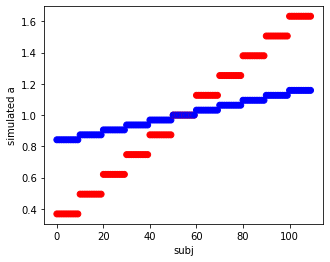

Text(0.5, 0, 'simulated a')

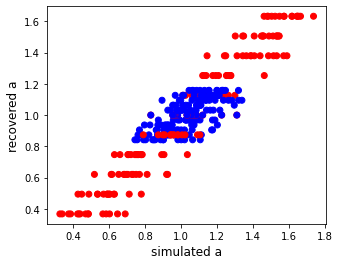

In [23]:
colors = np.where(subjdf["condition"]== 'level1','r','b')
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x=subjdf['apred'], y=subjdf['a_population'], c=colors)
ax.set_ylabel('recovered a', fontsize=12)
ax.set_xlabel('simulated a', fontsize=12)
#ax.set_title(f'Group: {idx}', fontsize=14)


In [27]:
subjdf2

,subj_idx,condition,Unnamed: 0,rt,response,z_x,x,a_population,apred
1,0.0,level2,200,0.298617,0.0,-1.581139,0.0,0.841886,0.843630
3,1.0,level2,600,0.264977,1.0,-1.581139,0.0,0.841886,0.866477
5,2.0,level2,1000,1.207483,0.0,-1.581139,0.0,0.841886,0.945138
7,3.0,level2,1400,0.586169,0.0,-1.581139,0.0,0.841886,0.712123
9,4.0,level2,1800,0.387311,0.0,-1.581139,0.0,0.841886,0.948888
...,...,...,...,...,...,...,...,...,...
211,105.0,level2,42200,0.911159,0.0,1.581139,10.0,1.158114,1.263550
213,106.0,level2,42600,1.182087,0.0,1.581139,10.0,1.158114,1.275427
215,107.0,level2,43000,1.232046,0.0,1.581139,10.0,1.158114,1.145139
217,108.0,level2,43400,0.391228,1.0,1.581139,10.0,1.158114,1.213300


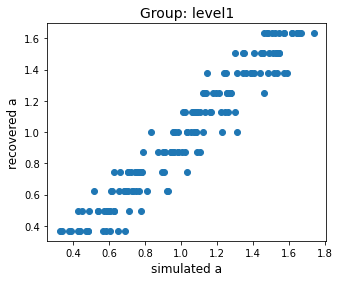

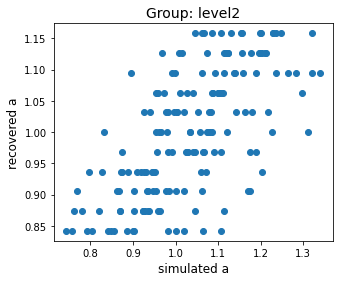

In [25]:
for idx, gp in subjdf.groupby('condition'):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(x=gp['apred'], y=gp['a_population'])
    
    ax.set_ylabel('recovered a', fontsize=12)
    ax.set_xlabel('simulated a', fontsize=12)
    ax.set_title(f'Group: {idx}', fontsize=14)
    
    plt.show()

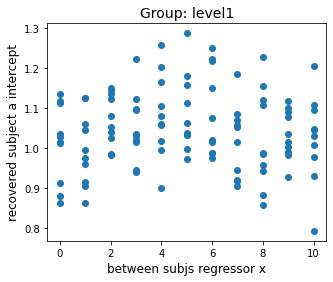

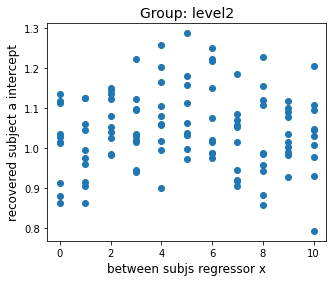

In [34]:
# correlation of subject intercept with between-subjects regressor
# should be zero correlation if entirely accounted for by x regressor - 
# this correlation should instead be positive if x is removed from the model fit

for idx, gp in subjdf.groupby('condition'):
    fig, ax = plt.subplots(figsize=(5,4))
    ax.scatter(x=gp['x'], y=gp['a_int_recovered'])
    
    ax.set_xlabel('between subjs regressor x', fontsize=12)
    ax.set_ylabel('recovered subject a intercept', fontsize=12)
    ax.set_title(f'Group: {idx}', fontsize=14)
    
    plt.show()